# League of legends match prediction


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [30]:
data = pd.read_csv("league_of_legends_data_large.csv")
data.head()

,win,kills,deaths,assists,gold_earned,cs,wards_placed,wards_killed,damage_dealt
0,0,16,6,19,17088,231,11,7,15367
1,1,8,8,5,14865,259,10,2,38332
2,0,0,17,11,15919,169,14,5,24642
3,0,19,11,1,11534,264,14,3,15789
4,0,12,7,6,18926,124,15,7,40268


In [31]:
#  target
X = data.drop('win', axis=1)
y = data['win']

In [32]:
# Splitting data into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

display(f'X_train shape: {x_train.shape}')
display(f'y_train shape: {y_train.shape}')
display(f'X_test shape: {x_test.shape}')
display(f'y_test shape: {y_test.shape}')

'X_train shape: (800, 8)'

'y_train shape: (800,)'

'X_test shape: (200, 8)'

'y_test shape: (200,)'

In [33]:
# Scaling data
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)

x_test = scaler.transform(x_test)

# converting to PyTorch tensor
x_train = torch.tensor(x_train, dtype = torch.float32)
x_test = torch.tensor(x_test, dtype = torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [34]:
# Creating model class
class logistic_regression(nn.Module):
    def __init__(self, n_inputs):
        super(logistic_regression, self).__init__()
        self.linear = nn.Linear(n_inputs, 1)
    def forward(self, x):
        yhat = torch.sigmoid(self.linear(x))
        return yhat

In [35]:
# Initializing model with the imput columns
model = logistic_regression(x_train.shape[1])

In [36]:
# Data loader
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [37]:
print(model)

logistic_regression(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)


In [38]:
# loss/cost function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [40]:
epochs = 100
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Training 
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_batch = y_batch.unsqueeze(1)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluating 
    model.eval()
    test_loss = 0.0
    correct_predictions = 0  
    total_samples = 0 
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            test_outputs = model(X_batch)
            y_batch = y_batch.unsqueeze(1)
            loss = criterion(test_outputs, y_batch)
            test_loss += loss.item()
            predicted_classes = (test_outputs > 0.5).float() 

            correct_predictions += (predicted_classes == y_batch).sum().item()
            total_samples += y_batch.numel()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    accuracy = correct_predictions / total_samples
    
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

Epoch [1/100], Train Loss: 0.6933, Test Loss: 0.7004, Test Accuracy: 0.4800
Epoch [2/100], Train Loss: 0.6905, Test Loss: 0.7006, Test Accuracy: 0.5050
Epoch [3/100], Train Loss: 0.6897, Test Loss: 0.6988, Test Accuracy: 0.5000
Epoch [4/100], Train Loss: 0.6901, Test Loss: 0.7015, Test Accuracy: 0.5100
Epoch [5/100], Train Loss: 0.6904, Test Loss: 0.7010, Test Accuracy: 0.4900
Epoch [6/100], Train Loss: 0.6903, Test Loss: 0.7009, Test Accuracy: 0.4950
Epoch [7/100], Train Loss: 0.6901, Test Loss: 0.6996, Test Accuracy: 0.4950
Epoch [8/100], Train Loss: 0.6898, Test Loss: 0.6994, Test Accuracy: 0.5100
Epoch [9/100], Train Loss: 0.6902, Test Loss: 0.6982, Test Accuracy: 0.5100
Epoch [10/100], Train Loss: 0.6898, Test Loss: 0.6974, Test Accuracy: 0.5150
Epoch [11/100], Train Loss: 0.6900, Test Loss: 0.6995, Test Accuracy: 0.5050
Epoch [12/100], Train Loss: 0.6902, Test Loss: 0.7001, Test Accuracy: 0.5100
Epoch [13/100], Train Loss: 0.6899, Test Loss: 0.7015, Test Accuracy: 0.5150
Epoch [1

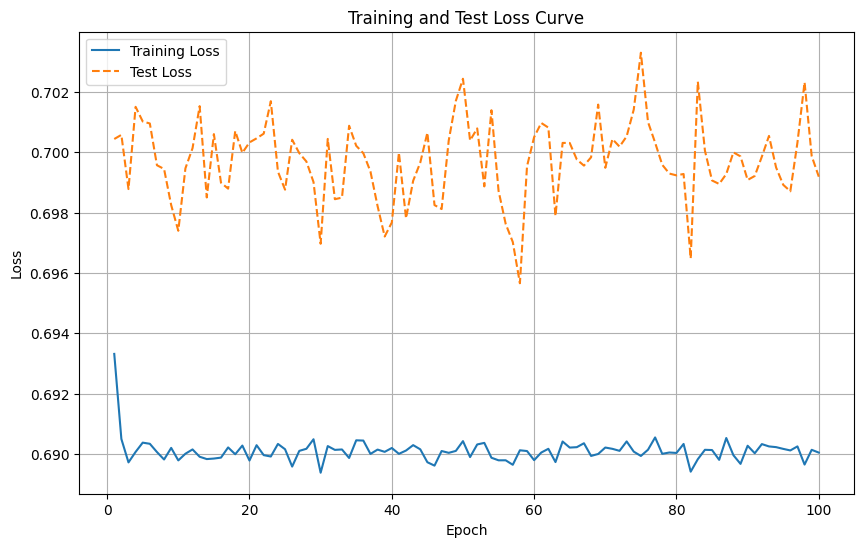

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# optimizer with weight decay
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

In [46]:
epochs = 1000
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    # Training 
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_batch = y_batch.unsqueeze(1)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluating  for both test and training datasets
    model.eval()
    test_loss = 0.0
    train_correct_predictions = 0  
    train_total_samples = 0 
    with torch.no_grad():
        for X_batch, y_batch in train_loader:
            train_outputs = model(X_batch)
            y_batch = y_batch.unsqueeze(1)
            predicted_train_classes = (train_outputs > 0.5).float()
            train_correct_predictions += (predicted_train_classes == y_batch).sum().item()
            train_total_samples += y_batch.numel()
    train_accuracy = train_correct_predictions / train_total_samples
    train_accuracies.append(train_accuracy)

    test_loss = 0.0
    test_correct_predictions = 0 
    test_total_samples = 0 
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            test_outputs = model(X_batch)
            y_batch = y_batch.unsqueeze(1)
            loss = criterion(test_outputs, y_batch)
            test_loss += loss.item()
            predicted_test_classes = (test_outputs > 0.5).float() 

            test_correct_predictions += (predicted_test_classes == y_batch).sum().item()
            test_total_samples += y_batch.numel()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    test_accuracy = test_correct_predictions / test_total_samples
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch [1/1000], Train Loss: 0.6901, Test Loss: 0.6987, Train Accuracy: 0.5450, Test Accuracy: 0.5200
Epoch [2/1000], Train Loss: 0.6894, Test Loss: 0.7000, Train Accuracy: 0.5537, Test Accuracy: 0.5200
Epoch [3/1000], Train Loss: 0.6898, Test Loss: 0.6986, Train Accuracy: 0.5475, Test Accuracy: 0.5200
Epoch [4/1000], Train Loss: 0.6903, Test Loss: 0.7003, Train Accuracy: 0.5413, Test Accuracy: 0.5150
Epoch [5/1000], Train Loss: 0.6901, Test Loss: 0.6994, Train Accuracy: 0.5413, Test Accuracy: 0.5050
Epoch [6/1000], Train Loss: 0.6899, Test Loss: 0.6973, Train Accuracy: 0.5387, Test Accuracy: 0.5100
Epoch [7/1000], Train Loss: 0.6904, Test Loss: 0.6991, Train Accuracy: 0.5437, Test Accuracy: 0.5200
Epoch [8/1000], Train Loss: 0.6902, Test Loss: 0.7013, Train Accuracy: 0.5363, Test Accuracy: 0.4900
Epoch [9/1000], Train Loss: 0.6900, Test Loss: 0.7019, Train Accuracy: 0.5387, Test Accuracy: 0.5000
Epoch [10/1000], Train Loss: 0.6898, Test Loss: 0.7048, Train Accuracy: 0.5425, Test Accura

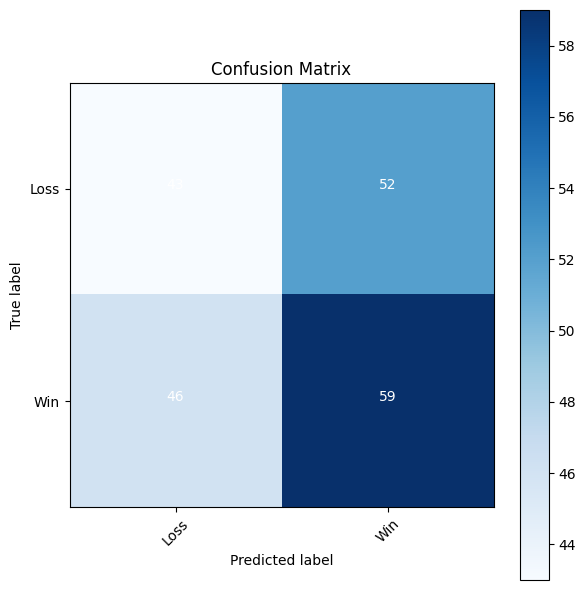

Classification Report:
               precision    recall  f1-score   support

        Loss       0.48      0.45      0.47        95
         Win       0.53      0.56      0.55       105

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.51       200
weighted avg       0.51      0.51      0.51       200



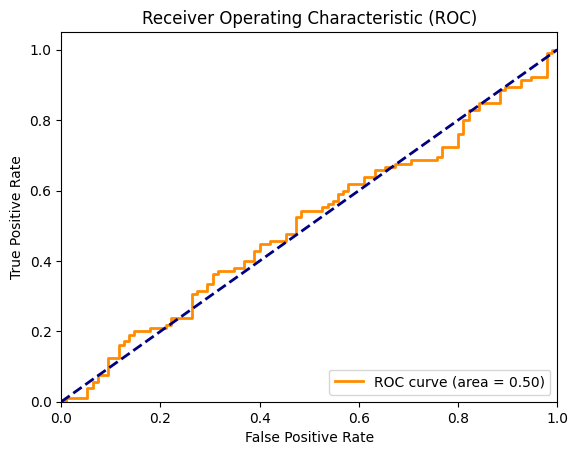

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import itertools
import torch
import numpy as np

all_true_labels = []
all_predicted_probabilities = []
all_predicted_classes = []
test_loss = 0.0 

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        test_outputs = model(X_batch)
        y_batch = y_batch.unsqueeze(1)
        loss = criterion(test_outputs, y_batch)
        test_loss += loss.item()
        
        predicted_batch_classes = (test_outputs > 0.5).float()
        
        all_predicted_probabilities.extend(test_outputs.cpu().numpy())
        all_true_labels.extend(y_batch.cpu().numpy())
        all_predicted_classes.extend(predicted_batch_classes.cpu().numpy())

y_true = np.array(all_true_labels).flatten()
y_pred_proba = np.array(all_predicted_probabilities).flatten()
y_pred_class = np.array(all_predicted_classes).flatten()

# Visualizing the confusion matrix
cm = confusion_matrix(y_true, y_pred_class)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['Loss', 'Win'], rotation=45)
plt.yticks(tick_marks, ['Loss', 'Win'])

thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# classification report
print("Classification Report:\n", classification_report(y_true, y_pred_class, target_names=['Loss', 'Win']))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# saving model weights
torch.save(model.state_dict(), 'league_of_legends_model.pth')

In [ ]:
# loading model
model = logistic_regression()

model.load_state_dict(torch.load('league_of_legends_model.pth'))

In [ ]:
model.eval()

In [58]:
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        test_outputs = model(X_batch)
        y_batch = y_batch.unsqueeze(1)
        loss = criterion(test_outputs, y_batch)
        test_loss += loss.item()
        predicted_test_classes = (test_outputs > 0.5).float() 

        test_correct_predictions += (predicted_test_classes == y_batch).sum().item()
        test_total_samples += y_batch.numel()

        test_accuracy = test_correct_predictions / test_total_samples
        test_accuracies.append(test_accuracy)

        print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.5100
Test Accuracy: 0.5099
Test Accuracy: 0.5116
Test Accuracy: 0.5115
Test Accuracy: 0.5131
Test Accuracy: 0.5131
Test Accuracy: 0.5147
Test Accuracy: 0.5162
Test Accuracy: 0.5162
Test Accuracy: 0.5161
Test Accuracy: 0.5177
Test Accuracy: 0.5160
Test Accuracy: 0.5160
Test Accuracy: 0.5159
Test Accuracy: 0.5159
Test Accuracy: 0.5142
Test Accuracy: 0.5158
Test Accuracy: 0.5173
Test Accuracy: 0.5157
Test Accuracy: 0.5172
Test Accuracy: 0.5171
Test Accuracy: 0.5186
Test Accuracy: 0.5170
Test Accuracy: 0.5170
Test Accuracy: 0.5169
Test Accuracy: 0.5153
Test Accuracy: 0.5153
Test Accuracy: 0.5152
Test Accuracy: 0.5152
Test Accuracy: 0.5152
Test Accuracy: 0.5151
Test Accuracy: 0.5166
Test Accuracy: 0.5165
Test Accuracy: 0.5165
Test Accuracy: 0.5164
Test Accuracy: 0.5164
Test Accuracy: 0.5163
Test Accuracy: 0.5163
Test Accuracy: 0.5147
Test Accuracy: 0.5162
Test Accuracy: 0.5176
Test Accuracy: 0.5161
Test Accuracy: 0.5175
Test Accuracy: 0.5160
Test Accuracy: 0.5159
Test Accur

In [64]:
# Hyper-parameter tuning

learning_rates= [0.01, 0.05, 0.1]

MODELS=[]

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
i = 0

def train_model_with_lr (iter, lr_list): 
    for i, lr in enumerate(lr_list):
        running_loss = 0.0
        model = logistic_regression(x_train.shape[1])
        optimizer = optim.SGD(model.parameters(), lr = lr)
        for epoch in range(iter):
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                y_batch = y_batch.unsqueeze(1)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        MODELS.append(model)
        
        test_loss = 0.0
        test_correct_predictions = 0 
        test_total_samples = 0 
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                test_outputs = model(X_batch)
                y_batch = y_batch.unsqueeze(1)
                loss = criterion(test_outputs, y_batch)
                test_loss += loss.item()
                predicted_test_classes = (test_outputs > 0.5).float() 

                test_correct_predictions += (predicted_test_classes == y_batch).sum().item()
                test_total_samples += y_batch.numel()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        test_accuracy = test_correct_predictions / test_total_samples
        test_accuracies.append(test_accuracy)
        i +=1
        print(f'Model_{i}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

train_model_with_lr(50, learning_rates)

Model_1: Test Loss: 0.7021, Test Accuracy: 0.5200
Model_2: Test Loss: 0.6992, Test Accuracy: 0.5050
Model_3: Test Loss: 0.7324, Test Accuracy: 0.4300


        Feature  Importance
3   gold_earned    0.167613
0         kills    0.129408
5  wards_placed    0.110595
1        deaths   -0.008251
2       assists   -0.009476
7  damage_dealt   -0.023750
4            cs   -0.040150
6  wards_killed   -0.042935


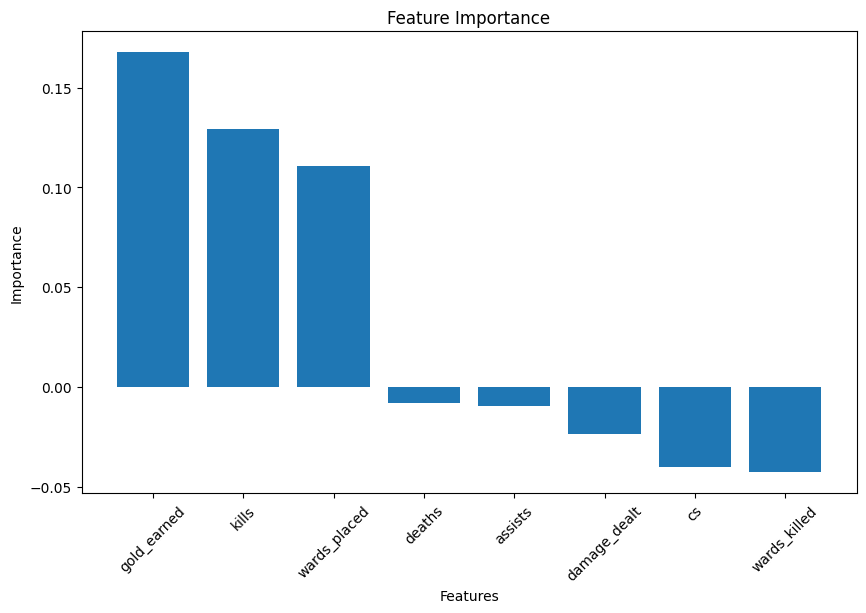

In [ ]:
# Important features of the dataset for model
weights = model.linear.weight.data.numpy().flatten()
features = X.columns

feature_importance = pd.DataFrame({'Feature': features, 'Importance': weights})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()